# Time Series Forecast for Melbourne Daily Min Temperatures

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

## EDA

In [2]:
# Load the data
df = pd.read_csv("../daily-min-temperatures.csv")

In [3]:
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [4]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3650 non-null   datetime64[ns]
 1   Temp    3650 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB


In [6]:
# Checking the Amount of Unique Years in the Dataset
print("There are ", len(df['Date'].dt.year.unique()), " Unique Years in this dataset. \n")
print(df['Date'].dt.year.unique())

There are  10  Unique Years in this dataset. 

[1981 1982 1983 1984 1985 1986 1987 1988 1989 1990]


In [7]:
df['Temp'].describe()

count    3650.000000
mean       11.177753
std         4.071837
min         0.000000
25%         8.300000
50%        11.000000
75%        14.000000
max        26.300000
Name: Temp, dtype: float64

In [8]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(df['Temp'], period=365)  # assuming yearly seasonality

## Some plotting for the data

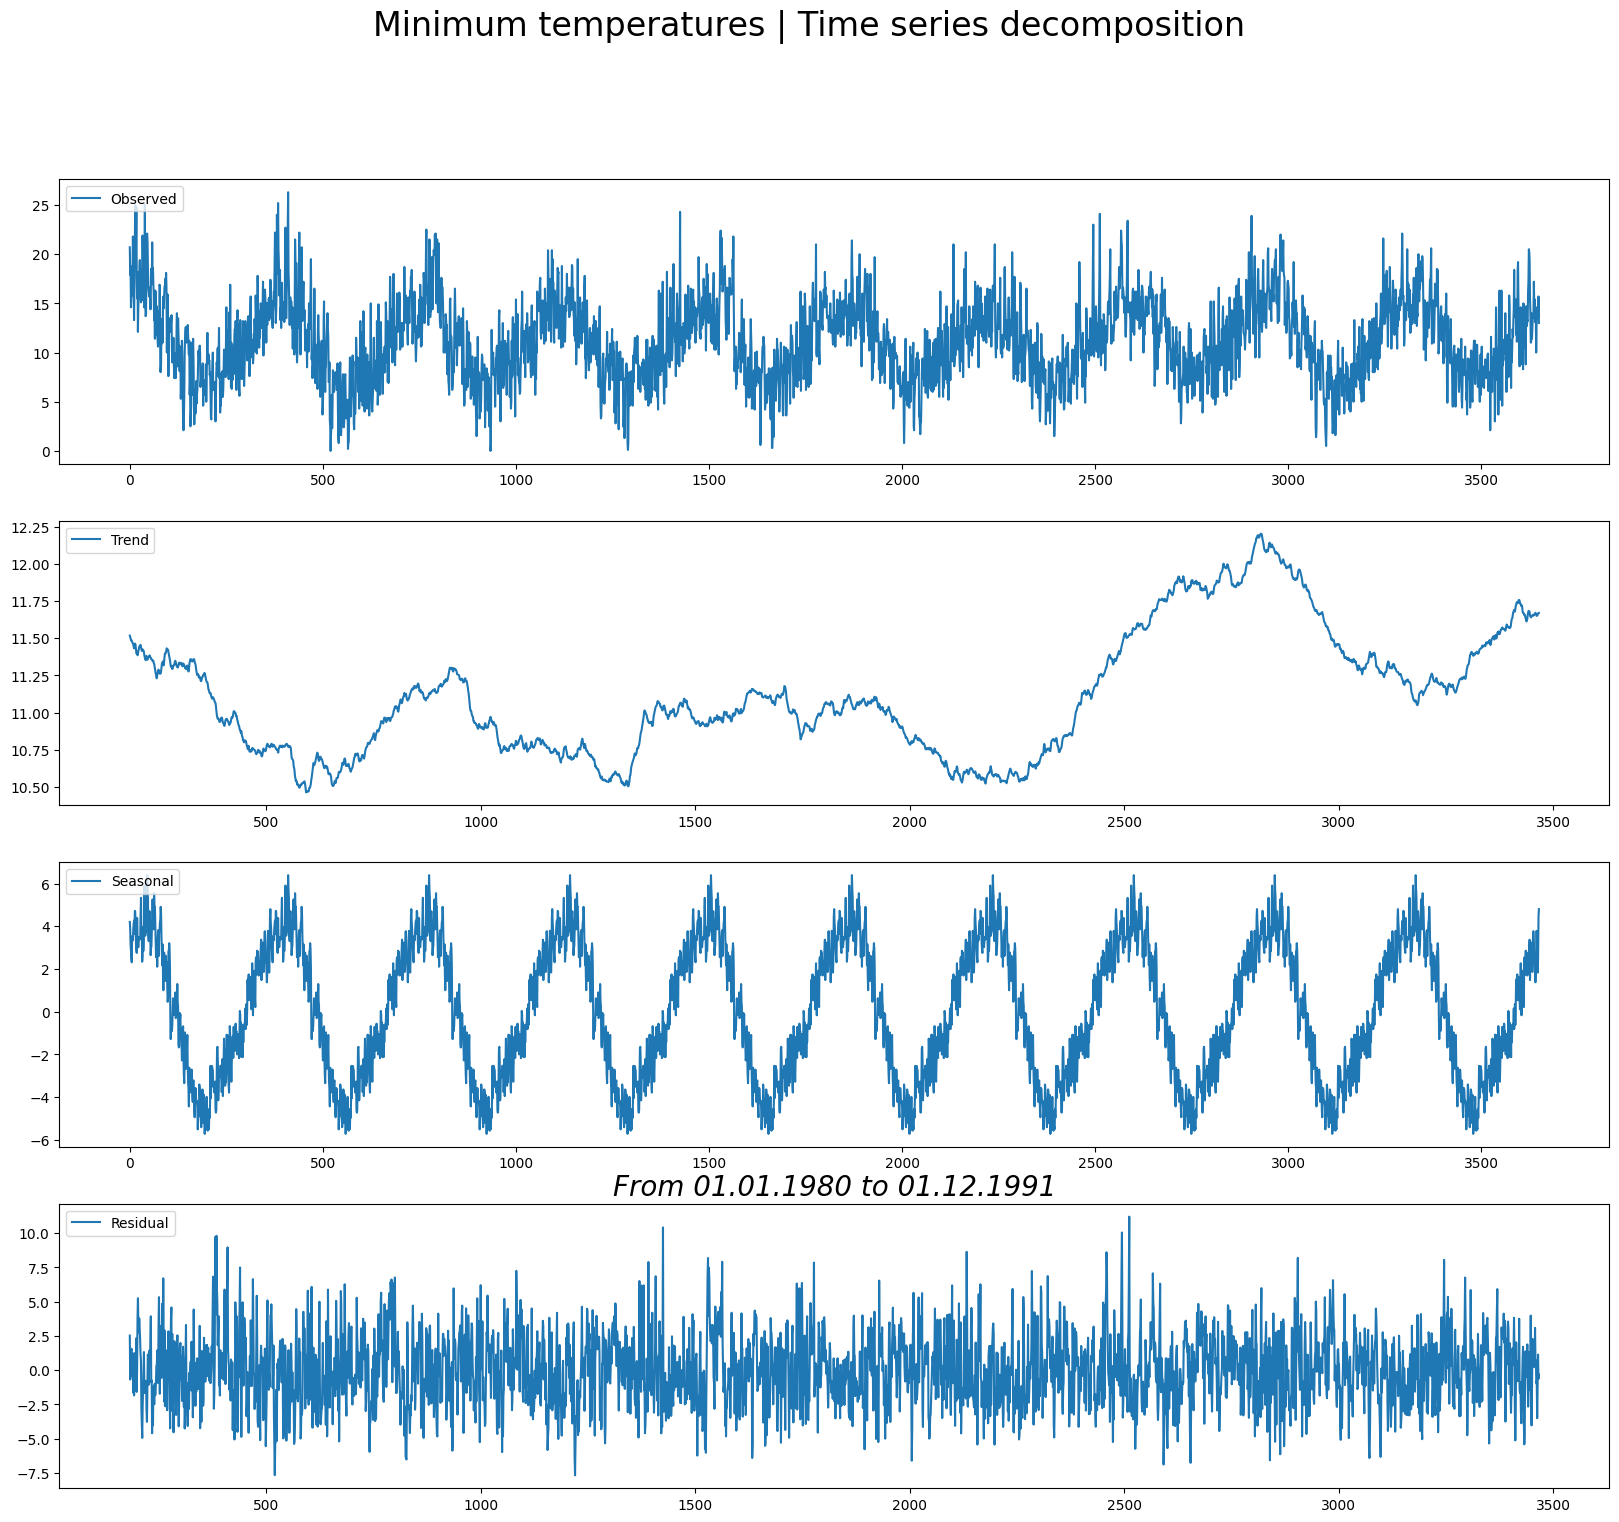

In [9]:
# Plot the decomposition
plt.figure(figsize=(20, 17))
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper left')
plt.suptitle('Minimum temperatures | Time series decomposition', fontsize=24)
plt.title('From 01.01.1980 to 01.12.1991', fontsize=20, style='italic')
plt.xlabel('')
plt.show()

In [10]:
# Create a copy of the DataFrame
df_2 = df.copy()

# Convert 'Date' column to datetime format and set it as index
df_2['Date'] = pd.to_datetime(df_2['Date'])
df_2.set_index('Date', inplace=True)

# Extract day and weekday information
df_2['Day'] = df_2.index.day.astype(str)  # Extract day of the month
df_2['Week'] = df_2.index.dayofweek.astype(str)  # Extract day of the week (Monday=0, Sunday=6)
df_2['Month'] = df_2.index.month.astype(str)  # Extract day of the week (Monday=0, Sunday=6)
df_2['Year'] = df_2.index.year.astype(str)  # Extract day of the week (Monday=0, Sunday=6)


df_2.head()

,Temp,Day,Week,Month,Year
Date,,,,,
1981-01-01,20.7,1,3,1,1981
1981-01-02,17.9,2,4,1,1981
1981-01-03,18.8,3,5,1,1981
1981-01-04,14.6,4,6,1,1981
1981-01-05,15.8,5,0,1,1981


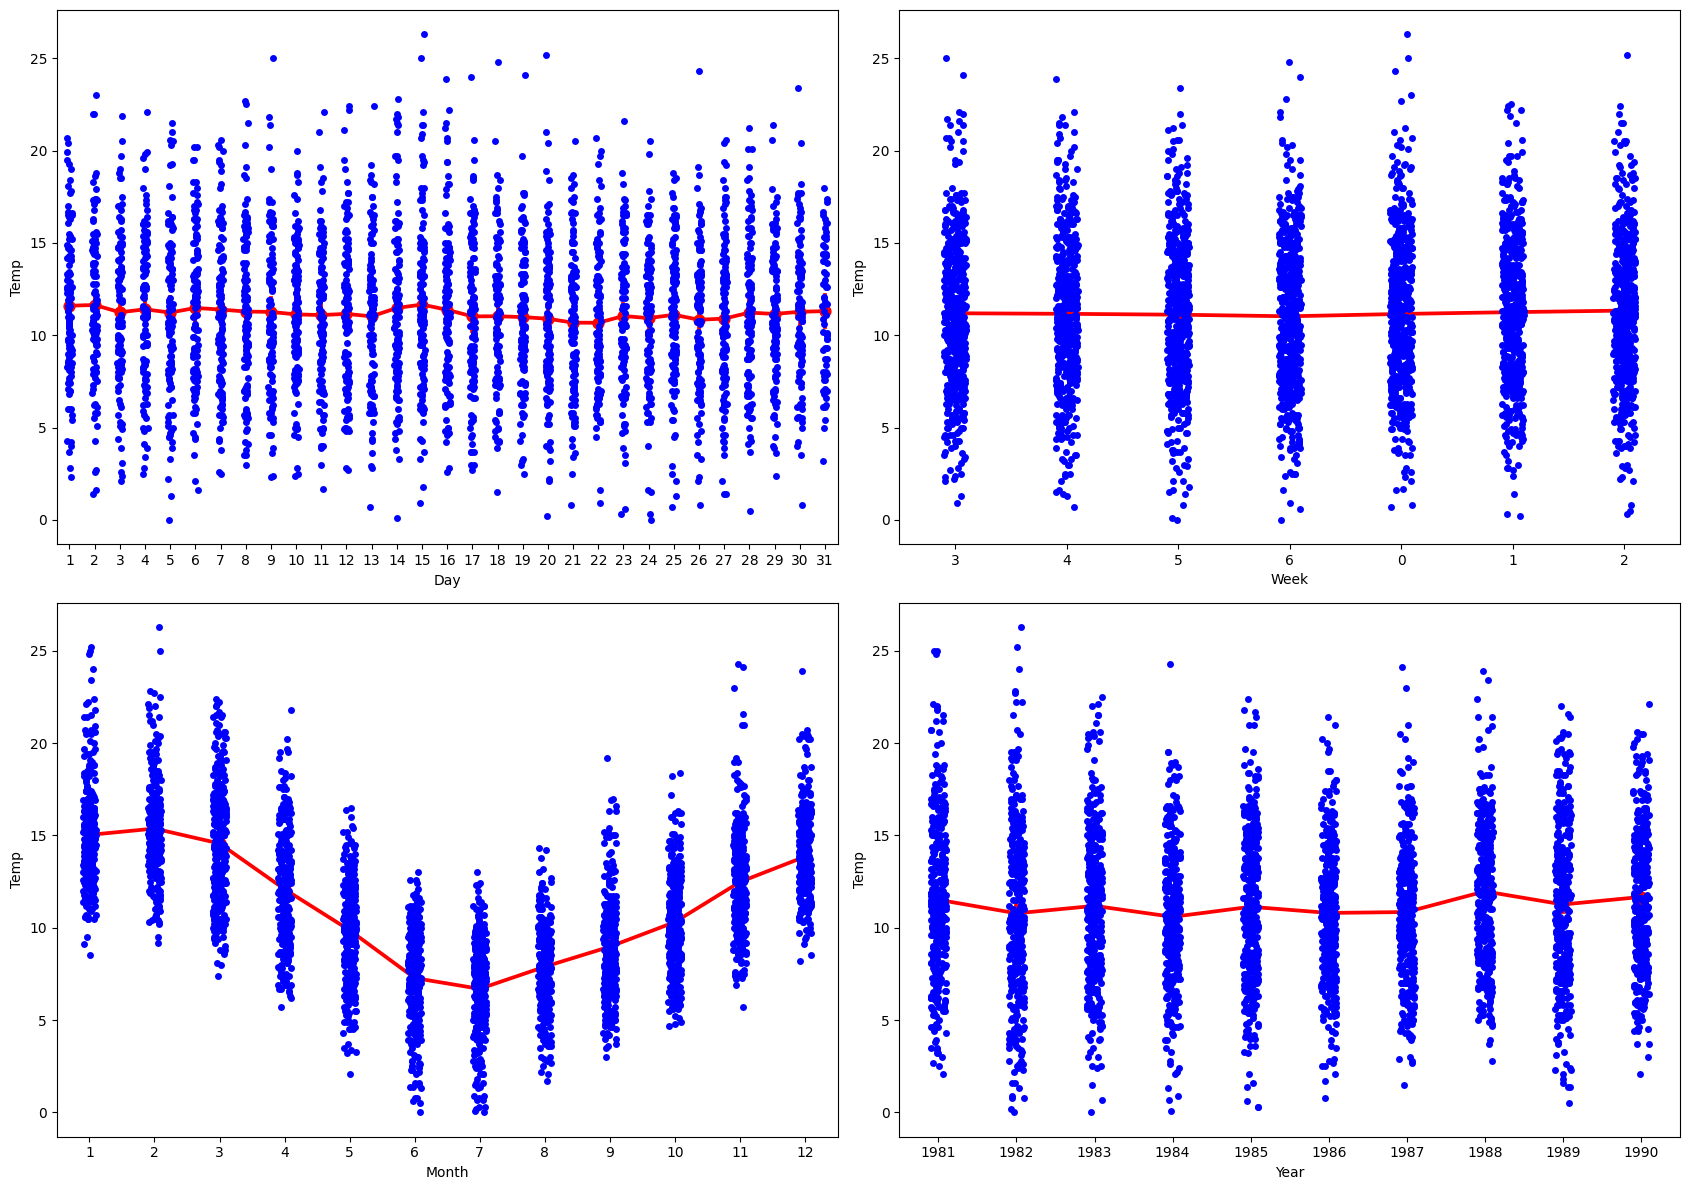

In [11]:
# Seasonal plots
plt.figure(figsize=(17, 12))

# Plot for Day
plt.subplot(2, 2, 1)
sns.stripplot(x='Day', y='Temp', data=df_2, jitter=True, color='blue')
sns.pointplot(x='Day', y='Temp', data=df_2, color='red')

# Plot for Week
plt.subplot(2, 2, 2)
sns.stripplot(x='Week', y='Temp', data=df_2, jitter=True, color='blue')
sns.pointplot(x='Week', y='Temp', data=df_2, color='red')

# Plot for Month
plt.subplot(2, 2, 3)
sns.stripplot(x='Month', y='Temp', data=df_2, jitter=True, color='blue')
sns.pointplot(x='Month', y='Temp', data=df_2, color='red')

# Plot for Year
plt.subplot(2, 2, 4)
sns.stripplot(x='Year', y='Temp', data=df_2, jitter=True, color='blue')
sns.pointplot(x='Year', y='Temp', data=df_2, color='red')

plt.tight_layout()
plt.show()

In [12]:
# Select relevant features
data = df_2[['Temp', 'Day', 'Week', 'Month', 'Year']]

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [13]:
# Define window size for input sequences
window_size = 30

# Create sequences of input data and corresponding labels
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, window_size)

# Split the data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## Modeling

In [14]:
# Create a LSTM model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dense(5)  # Adjust output dimension as needed
])

In [15]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/40
91/91 [==============================] - 11s 41ms/step - loss: 0.0593 - val_loss: 0.0387
Epoch 2/40
91/91 [==============================] - 2s 21ms/step - loss: 0.0358 - val_loss: 0.0313
Epoch 3/40
91/91 [==============================] - 3s 35ms/step - loss: 0.0316 - val_loss: 0.0317
Epoch 4/40
91/91 [==============================] - 4s 46ms/step - loss: 0.0270 - val_loss: 0.0245
Epoch 5/40
91/91 [==============================] - 3s 32ms/step - loss: 0.0206 - val_loss: 0.0156
Epoch 6/40
91/91 [==============================] - 2s 20ms/step - loss: 0.0151 - val_loss: 0.0136
Epoch 7/40
91/91 [==============================] - 1s 15ms/step - loss: 0.0140 - val_loss: 0.0133
Epoch 8/40
91/91 [==============================] - 1s 16ms/step - loss: 0.0132 - val_loss: 0.0122
Epoch 9/40
91/91 [==============================] - 1s 16ms/step - loss: 0.0128 - val_loss: 0.0120
Epoch 10/40
91/91 [==============================] - 1s 16ms/step - loss: 0.0119 - val_loss: 0.0111
Epoch 11

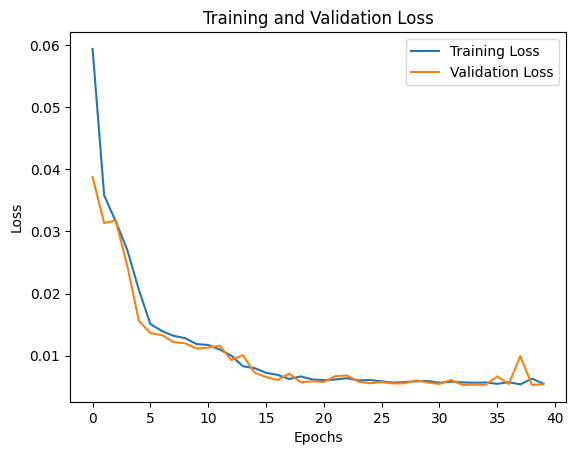

In [16]:
# Plot training and validation loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [17]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Inverse transform the predicted values to original scale
y_pred_inv = scaler.inverse_transform(y_pred)

# Inverse transform the actual test values to original scale
y_test_inv = scaler.inverse_transform(y_test)

23/23 [==============================] - 1s 8ms/step


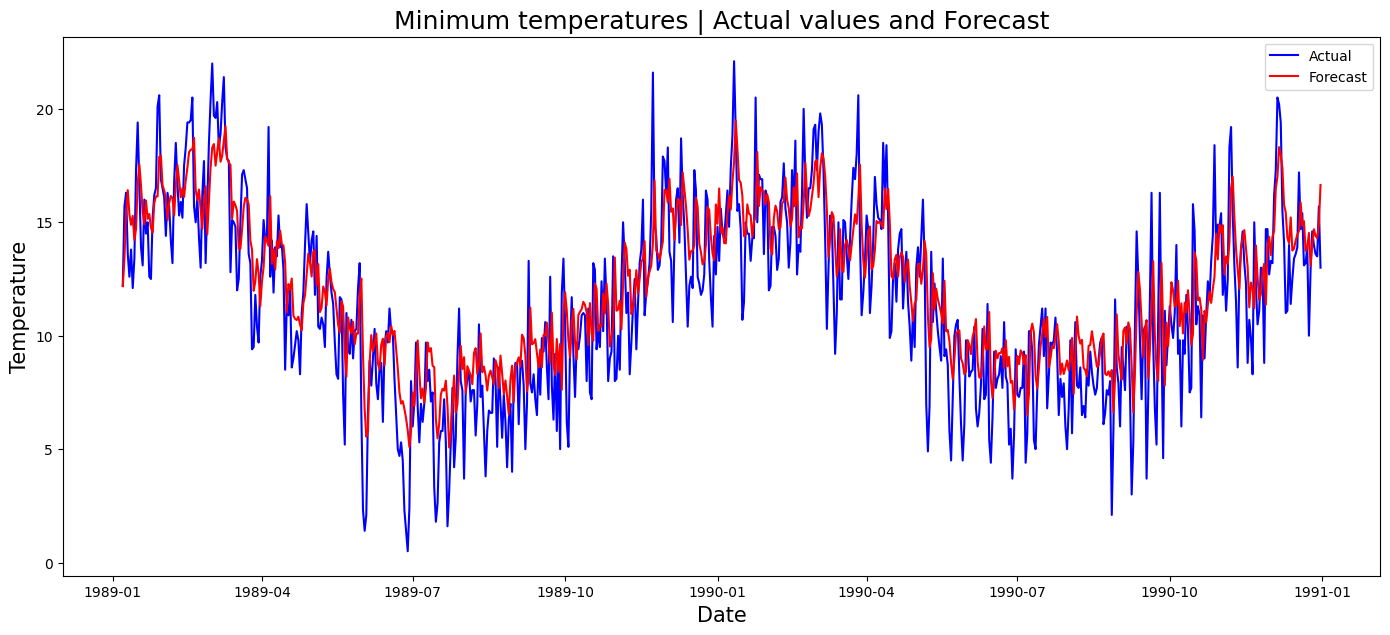

In [18]:
# Plot the original data, forecasted data, and actual data
plt.figure(figsize=(17, 7))
plt.plot(df_2.index[train_size + window_size:], y_test_inv[:, 0], label='Actual', color='blue')
plt.plot(df_2.index[train_size + window_size:], y_pred_inv[:, 0], label='Forecast', color='red')
plt.title('Minimum temperatures | Actual values and Forecast', fontsize=18)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.show()


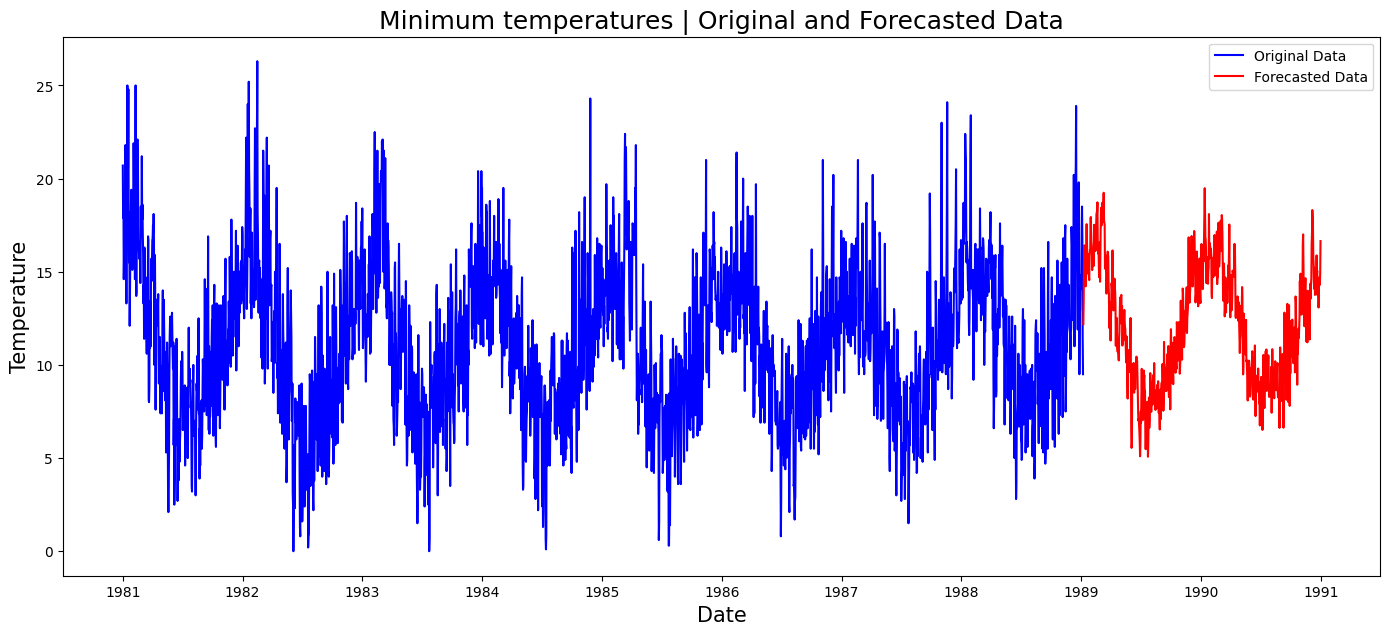

In [19]:
# Plot the first half of the original data
plt.figure(figsize=(17, 7))
plt.plot(df_2.index[:train_size + window_size], data['Temp'][:train_size + window_size], label='Original Data', color='blue')

# Plot the second half of the forecasted data
plt.plot(df_2.index[train_size + window_size:], y_pred_inv[:, 0], label='Forecasted Data', color='red')

plt.title('Minimum temperatures | Original and Forecasted Data', fontsize=18)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Temperature', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.show()

Evaluating the model’s predictive accuracy

In [20]:
mse = mean_squared_error(y_test_inv, y_pred_inv)
print("Mean Squared Error:", mse)

Mean Squared Error: 3.8761385095540506


In [21]:
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 1.9687911289809417


In [22]:
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.7319819561997042


In [23]:

r2 = r2_score(y_test_inv, y_pred_inv)
print("R-squared:", r2)

R-squared: 0.8740766245920761
